In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import numpy as np
import netCDF4 as nc

In [3]:
tos_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg/lexpt4_rr_mean_cfl_trunc_check_files/archive/output000/access-om3.mom6.2d.tos.1mon.snap.1900.nc'
tos = xr.open_dataset(tos_path)
tos

<xarray.Dataset> Size: 6MB
Dimensions:  (xh: 1440, yh: 1080, time: 1)
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -81.08 -80.97 -80.87 -80.76 ... 89.74 89.84 89.95
  * time     (time) object 8B 1900-01-02 00:00:00
Data variables:
    tos      (time, yh, xh) float32 6MB ...
Attributes:
    NumFilesInSet:     1
    title:             ACCESS-OM3
    associated_files:  areacello: access-om3.mom6.static.nc
    grid_type:         regular
    grid_tile:         N/A

In [4]:
sst = tos.tos.isel(time=1)-273.15
sst.plot()

IndexError: range object index out of range

In [6]:
ocean_hgrid_path = '/g/data/vk83/experiments/inputs/access-om3/mom/grids/mosaic/global.025deg/2020.05.30/ocean_hgrid.nc'
ocean_hgrid = xr.open_dataset(ocean_hgrid_path)
lons = ocean_hgrid.variables['x'][::2,::2]
lats = ocean_hgrid.variables['y'][::2,::2]
print(lons)
print(lats)

<xarray.Variable (nyp: 1081, nxp: 1441)> Size: 12MB
[1557721 values with dtype=float64]
Attributes:
    standard_name:  geographic_longitude
    units:          degree_east
<xarray.Variable (nyp: 1081, nxp: 1441)> Size: 12MB
[1557721 values with dtype=float64]
Attributes:
    standard_name:  geographic_latitude
    units:          degree_north


In [7]:
def load_topog_depth(topog_path = '/g/data/vk83/experiments/inputs/access-om3/share/grids/global.025deg/2023.05.15/topog.nc'):
    topog = xr.open_dataset(topog_path)
    depth = topog['depth']
    return depth

def load_lons_lats(ocean_hgrid_path = '/g/data/vk83/experiments/inputs/access-om3/mom/grids/mosaic/global.025deg/2020.05.30/ocean_hgrid.nc'):
    ocean_hgrid = xr.open_dataset(ocean_hgrid_path)
    lons = ocean_hgrid.variables['x'][::2,::2]
    lats = ocean_hgrid.variables['y'][::2,::2]
    return lons, lats

def find_indices_based_on_lon_lat(target_lon, target_lat, lons, lats):
    if hasattr(lons, 'values'):
        lons = lons.values
    if hasattr(lats, 'values'):
        lats = lats.values

    # Calculate the differences and find the index of the nearest lon/lat
    lon_diff = np.abs(lons - target_lon)
    lat_diff = np.abs(lats - target_lat)

    # Find the index where the differences are minimized
    min_lon_idx = np.unravel_index(np.argmin(lon_diff), lons.shape)
    min_lat_idx = np.unravel_index(np.argmin(lat_diff), lats.shape)

    # Combine the indices to get the nearest point
    nearest_lon_idx = min_lon_idx[1]
    nearest_lat_idx = min_lat_idx[0]
    nearest_idx = (nearest_lat_idx, nearest_lon_idx)

    # Print the nearest indices
    # print(f"Index of the closest point: {nearest_idx}")
    # print(f"Closest longitude: {lons[nearest_idx]} degrees")
    # print(f"Closest latitude: {lats[nearest_idx]} degrees")

    return nearest_idx, nearest_lon_idx, nearest_lat_idx

In [8]:
lons, lats = load_lons_lats()
nearest_idx, nearest_lon_idx, nearest_lat_idx = find_indices_based_on_lon_lat(57.83, 70.39, lons, lats)

In [9]:
topog_path = '/g/data/vk83/experiments/inputs/access-om3/share/grids/global.025deg/2023.05.15/topog.nc'
topog = xr.open_dataset(topog_path)
depth = topog['depth']

(877.0, 977.0)

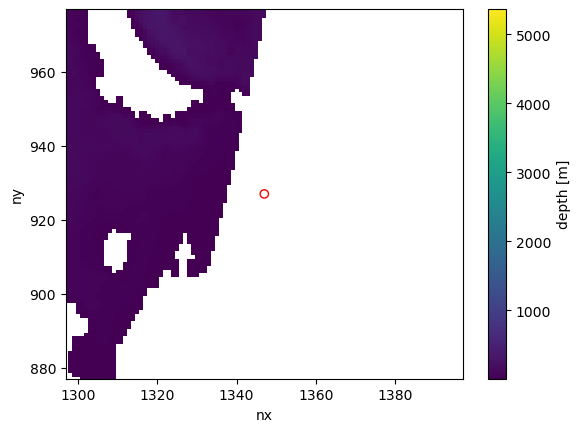

In [11]:
zoom_in = 50
depth.plot()
plt.scatter(nearest_lon_idx,nearest_lat_idx, facecolors='none', edgecolors='r')
plt.xlim(nearest_lon_idx-zoom_in,nearest_lon_idx+zoom_in)
plt.ylim(nearest_lat_idx-zoom_in,nearest_lat_idx+zoom_in)

In [134]:
# def load_truncation_files(truncation_file_path):
#     data = {}
#     time_pattern = r"Time\s+(\d+)\s+(\d+)\s+([\d.-]+)"
#     violation_pattern = r"(U|V)-velocity violation at \d+:\s+\d+\s+\d+\s+\(\s*([-]?\d+\.\d+)\s+E\s+([-]?\d+\.\d+)\s+N\)"
#     layers_pattern = r"Layers\s+(\d+)\s+to\s+(\d+)"
#     dt_pattern = r"dt\s+=\s+(\d+)"

#     with open(truncation_file_path, 'r') as f:
#         for l in f:
#             time_match = re.search(time_pattern, l)
#             if time_match:
#                 data['Year'] = int(time_match.group(1))
#                 data['Yearday'] = int(time_match.group(2))
#                 data['time'] = float(time_match.group(3))
#                 data['date'] = convert_to_date_time(data['Year'], data['Yearday'], data['time'])
#             violation_match = re.search(violation_pattern, l)
#             if violation_match:
#                 data['velocity'] = violation_match.group(1)
#                 data['target_lon'] = violation_match.group(2)
#                 data['target_lat'] = violation_match.group(3)
#             layers_match = re.search(layers_pattern, l)
#             if layers_match:
#                 data['layer_s'] = layers_match.group(1)
#                 data['layer_e'] = layers_match.group(2)
#             dt_match = re.search(dt_pattern, l)
#             if dt_match:
#                 data['dt'] = dt_match.group(1)
#     return data
def parse_truncation_file(truncation_file_path):
    lons, lats = load_lons_lats()

    violation_pattern = re.compile(
        r'Time\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([UV])-velocity violation at\s+(\d+):\s+\d+\s+\d+\s+\(\s*([-+]?\d*\.\d+)\s+[E]?\s+([-+]?\d*\.\d+)\s+[N]?\)\s+Layers\s+(\d+)\s+to\s+(\d+)\.\s+dt\s+=\s+(\d+)'
    )

    violations = []
    with open(truncation_file_path, 'r') as f:
        file_content = f.read()
    for match in violation_pattern.finditer(file_content):
        year = int(match.group(1))
        yearday = int(match.group(2))
        time_of_day = float(match.group(3))
        velocity_type = match.group(4) + '-velocity'
        processor = int(match.group(5))
        lon = float(match.group(6))
        lat = float(match.group(7))
        layer_start = int(match.group(8))
        layer_end = int(match.group(9))
        dt = int(match.group(10))

        
        nearest_idx, nearest_lon_idx, nearest_lat_idx = find_indices_based_on_lon_lat(lon, lat, lons, lats)
        # Convert year, yearday, and time to a datetime object
        datetime_value = convert_to_date_time(year, yearday, time_of_day)

        violations.append({
            'datetime': datetime_value,
            'velocity_type': velocity_type,
            'processor': processor,
            'longitude': lon,
            'latitude': lat,
            'longitude_index': nearest_lon_idx,
            'latitude_index': nearest_lat_idx,
            'layers_s': layer_start,
            'layers_e': layer_start,
            'dt': dt,
        })

    return violations

def convert_to_date_time(year, yearday, time):
    yearday = max(1, yearday)
    tmp = datetime(year, 1, 1)
    target_date = tmp + timedelta(days=yearday-1)

    hours = int(time)
    minutes = int((time-hours)*60)
    seconds = int((((time-hours)*60)-minutes)*60)
    target_datetime = target_date + timedelta(hours=hours, minutes=minutes, seconds=seconds)

    return target_datetime

def process_truncation_files(target_dir):
    all_truncation_data = []
    for output_dir in os.listdir(target_dir):
        output_dir_path = os.path.join(target_dir, output_dir)

        if os.path.isdir(output_dir_path) and output_dir.startswith('output'):
            for filename in os.listdir(output_dir_path):
                if filename.startswith("U_velocity_truncations") or filename.startswith("V_velocity_truncations"):
                    truncation_file_path = os.path.join(output_dir_path, filename)
                    truncation_data = parse_truncation_file(truncation_file_path)
                    if truncation_data:
                        all_truncation_data.append(truncation_data)
    return all_truncation_data

In [105]:
import os, re
from datetime import datetime, timedelta

In [135]:
data = process_truncation_files('/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg/longerexpt4_rr_mean_cfl_trunc_check_files/archive')
data

[[{'datetime': datetime.datetime(1900, 1, 1, 2, 48, 36),
   'velocity_type': 'V-velocity',
   'processor': 1026,
   'longitude': -57.62,
   'latitude': 57.29,
   'longitude_index': 894,
   'latitude_index': 779,
   'layers_s': 1,
   'layers_e': 1,
   'dt': 1350},
  {'datetime': datetime.datetime(1900, 1, 1, 2, 48, 36),
   'velocity_type': 'V-velocity',
   'processor': 1026,
   'longitude': -57.88,
   'latitude': 57.43,
   'longitude_index': 889,
   'latitude_index': 780,
   'layers_s': 1,
   'layers_e': 1,
   'dt': 1350},
  {'datetime': datetime.datetime(1900, 1, 1, 2, 48, 36),
   'velocity_type': 'V-velocity',
   'processor': 1026,
   'longitude': -57.62,
   'latitude': 57.43,
   'longitude_index': 894,
   'latitude_index': 780,
   'layers_s': 1,
   'layers_e': 1,
   'dt': 1350},
  {'datetime': datetime.datetime(1900, 1, 1, 2, 48, 36),
   'velocity_type': 'V-velocity',
   'processor': 1026,
   'longitude': -57.88,
   'latitude': 57.56,
   'longitude_index': 889,
   'latitude_index': 7

In [10]:
static_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg/lexpt4_rr_mean_cfl_trunc_check_files/archive/output000/access-om3.mom6.static.nc'
static = xr.open_dataset(static_path)
static

<xarray.Dataset> Size: 137MB
Dimensions:       (xh: 1440, yh: 1080, time: 1, xq: 1440, yq: 1080)
Coordinates:
  * xh            (xh) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yh            (yh) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time          (time) object 8B 1900-01-01 00:00:00
  * xq            (xq) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yq            (yq) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
Data variables: (12/22)
    areacello     (yh, xh) float32 6MB ...
    areacello_cu  (yh, xq) float32 6MB ...
    areacello_cv  (yq, xh) float32 6MB ...
    areacello_bu  (yq, xq) float32 6MB ...
    dxt           (yh, xh) float32 6MB ...
    dyt           (yh, xh) float32 6MB ...
    ...            ...
    wet_c         (yq, xq) float32 6MB ...
    wet_u         (yh, xq) float32 6MB ...
    wet_v         (yq, xh) float32 6MB ...
    Coriolis      (yq, xq) float32 6MB ...
    sin_rot       (yh, xh) float32 6MB ...
    cos_rot       (yh, xh) float32 6MB ...
Attributes:
    NumFilesInSet:  1
    title:          ACCESS-OM3
    grid_type:      regular
    grid_tile:      N/A

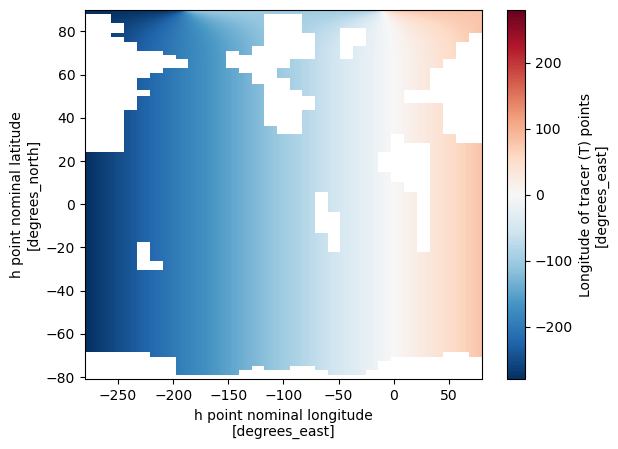

In [12]:
static['geolon'].plot()

In [8]:
grid_path = '/g/data/vk83/experiments/inputs/access-om3/cice/grids/global.025deg/2024.05.14/grid.nc'
grid = xr.open_dataset(grid_path)
grid

<xarray.Dataset> Size: 124MB
Dimensions:  (nj: 1080, ni: 1440)
Coordinates:
    ulat     (nj, ni) float64 12MB ...
    ulon     (nj, ni) float64 12MB ...
    tlat     (nj, ni) float64 12MB ...
    tlon     (nj, ni) float64 12MB ...
Dimensions without coordinates: nj, ni
Data variables:
    htn      (nj, ni) float64 12MB ...
    hte      (nj, ni) float64 12MB ...
    angle    (nj, ni) float64 12MB ...
    anglet   (nj, ni) float64 12MB ...
    tarea    (nj, ni) float64 12MB ...
    uarea    (nj, ni) float64 12MB ...
    crs      |S1 1B ...
Attributes:
    Conventions:  CF-1.6
    inputfile:    /g/data/vk83/experiments/inputs/access-om3/mom/grids/mosaic...
    history:      Created using https://github.com/COSIMA/esmgrids 0.1.1: cic...

In [5]:
geolon = static.geolon_t
geolat = static.geolat_t

AttributeError: 'Dataset' object has no attribute 'geolon_t'